# 9. Spatial Gillespie Method

## 9.1. E-Cell4 における空間表現

E-Cell4における空間表現とはどのようなものでしょうか?


In [1]:
from ecell4 import *
from ecell4_base import *
from ecell4_base.core import *

w1 = ode.World(ones())
w2 = gillespie.World(ones())

`ODEWorld` と `GillespieWorld` にサイズ `1` の立方体を作成しました。 この場合、重要なのはボリュームのみです。


In [2]:
w3 = ode.World(Real3(2, 0.5, 1))  # is almost equivalent to 'w1'
w4 = gillespie.World(Real3(2, 2, 0.25))  # is almost equivalent to 'w2'

これは同じ結果を返します。 ボリュームが 同じ `1` であるためです。

これは均一な系では妥当ですが、細胞は均一な系ではありません。
したがって、我々は分子の局在化のために空間表現を考慮する必要があります。

E-Cell4では、いくつかのタイプの空間表現とシミュレーション方法を使用できます。
ここではSpatial Gillespie Methodの例を示します。


## 9.2. Spatial Gillespie Method

E-Cell4では、Spatial Gillespie Method が `meso` モジュールに含まれています。 

まずは `ode` でのように `run_simulation`から始めてみましょう。


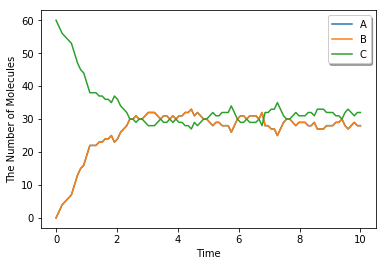

In [3]:
%matplotlib inline
import numpy
from ecell4 import *

with reaction_rules():
    A + B == C | (0.01, 0.3)

run_simulation(numpy.linspace(0, 10, 100), {'C': 60}, solver='meso')

定常状態においては、 `C` の数は以下のように与えられます。

$$
\frac{d\mathrm{C}}{dt}=0.01{\cdot}\frac{\mathrm{A}}{V}{\cdot}\frac{\mathrm{B}}{V}-0.3{\cdot}\frac{\mathrm{C}}{V}=0\\
0.01\left(60-\mathrm{C}\right)^2=0.3\mathrm{C}\times V\\
\mathrm{C}=30.
$$

あなたは `ode` や `gillespie` とほとんど同じ結果を得るでしょう (`ode` や `gillespie` よりも時間はかかるかもしれません)。

これは当然のことです。なぜなら、`meso` モジュールは、追加の空間パラメータを与えない限り、Gillespieとほぼ同じだからです。

次に、 `run_simulation`を分解して見てみましょう。


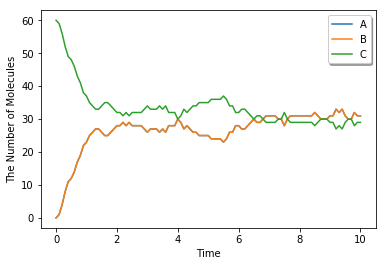

In [4]:
from ecell4 import *
from ecell4_base import *
from ecell4_base.core import *

with reaction_rules():
    A + B == C | (0.01, 0.3)

m = get_model()

w = meso.World(ones(), Integer3(1, 1, 1))  # XXX: Point2
w.bind_to(m)  # XXX: Point1
w.add_molecules(Species('C'), 60)

sim = meso.Simulator(w)  # XXX: Point1
obs = FixedIntervalNumberObserver(0.1, ('A', 'B', 'C'))
sim.run(10, obs)

show(obs)

これは `meso.World` と `meso.Simulator` を除いて普段のものと変わりませんが、いくつかの新しい要素が見えるかと思います。

まず `w.bind_to(m)` で、`Model` を `World` に関連付けました。
以前の基本的な演習では、私たちはこれをしませんでした。

spatial methodでは、`Species` の属性が必要です。 これを忘れないでください。
その後、 `meso.Simulator`を作るためには `World` だけが必要です。

次に、重要な違いは、`meso.World` の2番目の引数、すなわち `Integer3(1,1,1)` です。
`ODEWorld`と` GillespieWorld`はこの第二引数を持っていません。
これを説明する前に、この引数を変更してシミュレーションを再実行してみましょう。


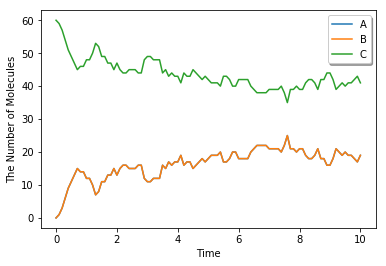

In [5]:
from ecell4 import *
from ecell4_base import *
from ecell4_base.core import *

with reaction_rules():
    A + B == C | (0.01, 0.3)

m = get_model()

w = meso.World(ones(), Integer3(4, 4, 4))  # XXX: Point2
w.bind_to(m)  # XXX: Point1
w.add_molecules(Species('C'), 60)

sim = meso.Simulator(w)  # XXX: Point1
obs = FixedIntervalNumberObserver(0.1, ('A', 'B', 'C'))
sim.run(10, obs)

show(obs)

先程とは異なるプロットが出ているはずです。
`Integer3` の値を大きくすると、より大きく異なっているプロットになるでしょう。

実は、この第2引数は、空間パーティションの数を意味します。

`meso` は `gillespie` とほぼ同じですが、`meso` は空間を立方体に分割します（我々はこの立方体をサブボリュームと呼んでいます）。
そして `gillespie` がただ1つの均一な閉鎖空間を持つのとは対照的に、各サブボリュームは異なる分子濃度を有します。

したがって、前の例では、我々は `1` の辺を持つ1つの立方体を，辺 `0.25` の64(4*4*4) 個の立方体に分割したわけです。

そして次に60個の `C` 分子を `World` に投げました。したがって、各サブボリュームにはせいぜい1つのspeciesしかないわけです。


## 9.3. 分子の拡散係数の定義

先程の違いはどこから来ているのでしょうか?

これは `meso` で `space` を得たにもかかわらず，分子の拡散係数を考慮していないためです。

拡散係数を設定するには、前に([2. モデルの構築方法](tutorial2-ja.ipynb)) で述べた方法で `Species` の attribute `D` を使います。

[1. E-Cell4シミュレーションの概要](tutorial1-ja.ipynb) でお見せしたように，ここでは E-Cell4 の特殊記法を用います。


In [6]:
with species_attributes():
    A | {'D': '1'}
    B | {'D': '1'}
    C | {'D': '1'}

    # A | B | C | {'D': '1'}  # means the same as above

get_model()

`with species_attributes():` ステートメントで拡散係数を設定することができます。

ここでは、すべての拡散係数を `1` に設定します。このモデルをもう一度シミュレートしましょう。

今度は、大きな `Integer3` の値でも `gillespie` とほぼ同じ結果を得るはずです（シミュレーションには `gillespie` よりはるかに時間がかかります）。

分子拡散は問題に対してどのように働いたのでしょうか?

3D空間で自由拡散 (Speciesの拡散係数は $D$ )を考えてみましょう。

拡散係数の単位は、

$ \mathrm{\mu m}^2/s $ or $ \mathrm{nm}^2/\mu s $

のように(空間の)長さの2乗を時間で割ったものです。

時間$ 0 $から$ t $までの点の距離の平方の平均が$ 6Dt $に等しいことが知られています。

逆に、長さスケール$ l $の空間における時間スケールの平均は約$ l ^ 2 / 6D $です。

上記の場合、各サブボリュームのサイズは0.25であり、拡散係数は1です。
したがって、時間スケールは約0.01秒になります。

`Species` `A` と `B` の分子が同じサブボリュームにある場合、反応に約1.5秒かかるので、ほとんどの場合、拡散は反応よりも速く、同じサブボリュームで解離した場合でも分子は他のサブボリュームに移動します。

小さな $l$ では、より小さなサブボリュームの体積 $l^3$ となるので、解離後の反応速度は速くなり、サブボリューム間の拡散時間と遷移時間も小さくなります。

## 9.4. 分子の局在

我々は `add_molecules` 関数を使って、`ode` や `gillespie` と同じように `World` に分子を追加しました。
一方、 `meso.World` では、空間表現に従って分子を入れることができます。


In [7]:
from ecell4 import *
from ecell4_base import *
from ecell4_base.core import *

w = meso.World(ones(), Integer3(3, 3, 3))
w.add_molecules(Species('A'), 120)
w.add_molecules(Species('B'), 120, Integer3(1, 1, 1))

`meso.World` では、第3引数 `Integer3` を `add_molecules` に与えることでサブボリュームと分子の位置を設定できます。

上記の例では、Speciesタイプ `A` は空間全体に広がっていますが、Speciesタイプ `B` は、ボリュームの中心のサブボリュームにのみ位置するようになっています。

またこれらの一情報をチェックするには、座標と共に `num_molecules`関数を使います。


In [8]:
print(w.num_molecules(Species('B')))  # must print 120
print(w.num_molecules(Species('B'), Integer3(0, 0, 0)))  # must print 0
print(w.num_molecules(Species('B'), Integer3(1, 1, 1)))  # must print 120

120
0
120


さらに、Jupyter Notebook 環境があれば、 `ecell4.viz` モジュールを使って分子の位置を可視化することができます。


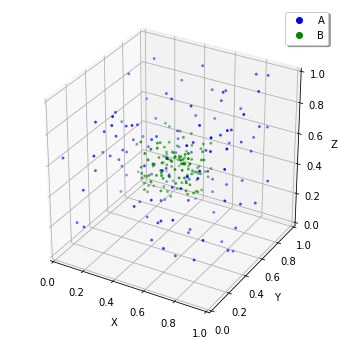

In [9]:
# viz.plot_world(w, radius=0.01)
viz.plot_world(w, interactive=False)

`viz.plot_world` 関数は、 `World` を与えることによって、Jupyter Notebookのセルで分子の位置を可視化します。

分子のサイズは `radius` で設定できます。

それでは 分子の局在を `World` に設定し、これをシミュレートしてみましょう。

上記の例では、拡散係数 `1` とWorldサイズ `1` を設定しているので、かき混ぜる時間は `10` 秒で十分です。

シミュレーションの後で `viz.plot_world` を再度呼び出して結果を確認してください。


## 9.5. 分子の初期位置とその反応

これは、分子の局在が反応にどのように影響するかを調べる極端な例です。


In [10]:
%matplotlib inline
from ecell4 import *
from ecell4_base import *
from ecell4_base.core import *

with species_attributes():
    A | B | C | {'D': '1'}

with reaction_rules():
    A + B > C | 0.01

m = get_model()
w = meso.World(Real3(10, 1, 1), Integer3(10, 1, 1))
w.bind_to(m)

このモデルは単純な結合反応のみからなります。
`World` はx軸に長い直方体であり、分子は中心から離れた位置にあります。

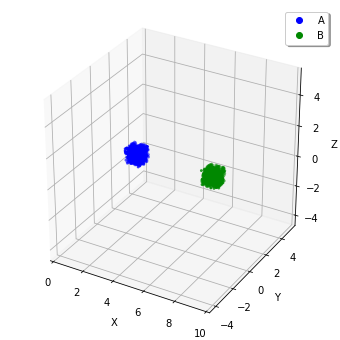

In [11]:
w.add_molecules(Species('A'), 1200, Integer3(2, 0, 0))
w.add_molecules(Species('B'), 1200, Integer3(7, 0, 0))
# viz.plot_world(w, radius=0.025)
viz.plot_world(w, interactive=False)

別の注意点として、`Integer3(0, 0, 0)` または `Integer3(9, 0, 0)` を設定しない理由があります。

E-Cell4では、基本的にすべてに周期的境界条件を採用しています。

したがって、前述の2つのサブボリュームは実際には隣接しています。

期待される位置を実現した後、 `meso.Simulator` でシミュレートしてみましょう。


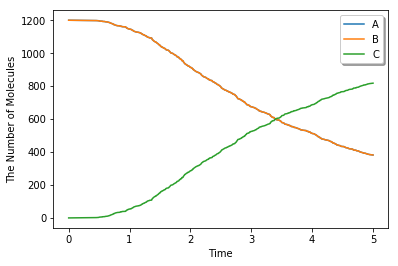

In [12]:
sim = meso.Simulator(w)
obs1 = NumberObserver(('A', 'B', 'C'))  # XXX: saves the numbers after every steps
sim.run(5, obs1)
show(obs1)

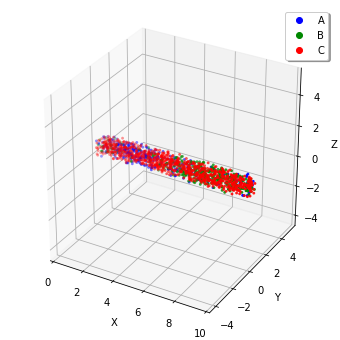

In [13]:
# viz.plot_world(w, radius=0.025)
viz.plot_world(w, interactive=False)

初期座標の効果を確認するには、分子を `meso` で均一に配置するか、 `gillespie` でシミュレートすることをお勧めします。


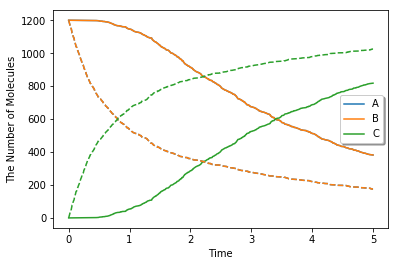

In [14]:
w = meso.World(Real3(10, 1, 1), Integer3(10, 1, 1))
w.bind_to(m)
w.add_molecules(Species('A'), 1200)
w.add_molecules(Species('B'), 1200)

sim = meso.Simulator(w)
obs2 = NumberObserver(('A', 'B', 'C'))  # XXX: saves the numbers after every steps
sim.run(5, obs2)
show(obs1, "-", obs2, "--")

実線はバイアスをかけたケースで、破線はかけていないものになります。

バイアスがかかっている場合の反応は明らかに遅いです。

また、時系列の形状も実線と破線の間で異なっていることがわかります。

これは、最初の分離のために分子AおよびBが衝突するのにある程度の時間がかかるからです。

実際には、`A` と `B` の間の最初の距離（約4）を移動するにはおよそ $4^2/2(D_\mathrm{A}+D_\mathrm{B})=4$ 秒かかります。
